<a href="https://colab.research.google.com/github/Thalliacaveionn/classificacao_video_por_fala/blob/main/modelo_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classificação de vídeos **com fala**, **sem fala**, **misto** e com **ruidos**

##Importando as bibliotecas necessárias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pathlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display as ld
from IPython.display import Audio
from tqdm import tqdm
import tensorflow
print('Versão Tensorflow: ', tensorflow.__version__)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

Mounted at /content/drive
Versão Tensorflow:  2.9.2


##Base de dados é de autoria própria


*   Este conjunto de dados contém 587 trechos de vídeo em formato .wmv que posteriormente serão transformados em formato .wav para estudo do som, o conjunto está divido em 6 classes:
  1. Com fala (classificado por 1)
  2. Sem fala (classificado por 0
  3. Misto (classificado por 2)
  4. Sem fala e ruídos (classificado por 3)
  5. Com fala e ruídos (classificado por 4)
  6. Misto e ruídos (classificado por 5) 

O nome do arquivo de vídeo tem o seguinte formato (trecho)-(video_id)-(start)-(end)-(class_id).wav



*   Trecho - nome do trecho de cada vídeo levando em conta o vídeo original
*   Video_id - id do vídeo original
*   Star - minutagem inical do trecho levando em conta a minutagem do vídeo original
*   End - minutagem final do trecho levando em conta a minutagem do vídeo original
*   Class_id - id de classificação do trecho

Meta dados
Os arquivos .wav estão na pasta /videos no google drive

In [ ]:
nome_list = []
video_id = []
start_list = []
end_list = []
class_id = []
full_path = []

caminho = '/content/drive/My Drive/UTFPR/videos/base_toda_ruidos_classe_unica/'

for root, dirs, files in os.walk(caminho):
  for file in files:
    try:
      nome = int(file.split('-')[0])
      video = int(file.split('-')[1])
      start = int(file.split('-')[2])
      end = int(file.split('-')[3])
      classe = file.split('-')[4]
      classe= int(classe.split('.')[0])

      nome_list.append(nome)
      video_id.append(video)
      start_list.append(start)
      end_list.append(end)
      class_id.append(classe)

      full_path.append((root, file))
    except ValueError:
      continue

print(nome_list)
print(video_id)
print(start_list)
print(end_list)
print(class_id)
print(full_path)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 8, 8, 8, 8, 8, 29, 28, 27, 26, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 25, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 9, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4

Criando o dicionário de classe

In [ ]:
sound_list = ['sem-fala', 'com-fala', 'misto', 
              'sem-fala-ruido', 'com-fala-ruido', 'misto-ruido']
sound_dict = {em[0]:em[1] for em in enumerate(sound_list)}
print(sound_dict)

{0: 'sem-fala', 1: 'com-fala', 2: 'misto', 3: 'sem-fala-ruido', 4: 'com-fala-ruido', 5: 'misto-ruido'}


In [ ]:
# Data frame 
df = pd.DataFrame([nome_list, video_id, class_id, full_path]).T
df.columns = ['trecho', 'video_id', 'class_id', 'path']

In [ ]:
df['class_id'] = df['class_id'].map(sound_dict)
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [ ]:
df['class_id'].value_counts()

com-fala-ruido    104
sem-fala-ruido    104
com-fala          103
misto-ruido       100
misto              90
sem-fala           86
Name: class_id, dtype: int64

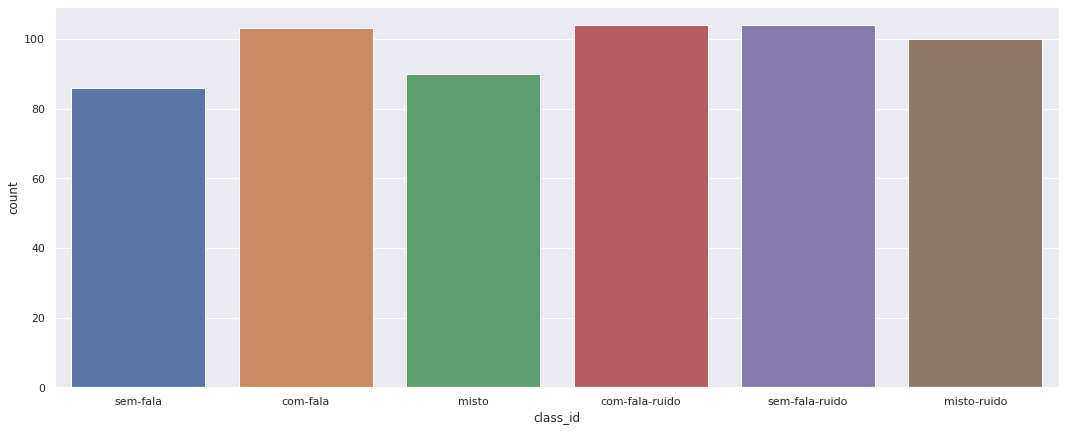

In [ ]:
plt.figure(figsize=(18,7))
sns.countplot(df['class_id']);

##Pré-processamento

Extraindo recursos/características MFCC's de cada arquivo de áudio

In [ ]:
def features_extractor(file_name):
  # res_type pode ser 'kaiser_best', 'kaiser_fast', 'scipy', 'polyphase'
  data, sample_rate = librosa.load(file_name, sr = None, res_type = 'kaiser_best')
  mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc=40)
  mfcss_features_scaled = np.mean(mfccs_features.T, axis = 0)
  return mfcss_features_scaled

In [ ]:
extracted_features = []
for path in tqdm(df['path'].values):
  data = features_extractor(path)
  extracted_features.append([data])

100%|██████████| 587/587 [00:07<00:00, 76.94it/s]


In [ ]:
print("Quantidade de arquivos de audio: ",len(extracted_features))
print(np.array(extracted_features[0]).shape)

Quantidade de arquivos de audio:  587
(1, 40)


In [ ]:
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature'])

##Dividindo entre atributos classe(class) e atributos previsores(features)

In [ ]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(df['class_id'].tolist())

Converter os valore de y que estão em string para numérico

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

##divisão entre base de treino e base de teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state=1)

In [ ]:
X_train.shape, X_val.shape

((293, 40), (147, 40))

In [ ]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_val = X_val[:,:,np.newaxis]

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((293, 40, 1), (147, 40, 1), (147, 40, 1))

##Criação do modelo

Rede neural convulacional

In [ ]:
model = Sequential()

model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 10, padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Flatten())

model.add(Dense(units = 64))
model.add(Dropout(0.4))
model.add(Dense(units = 6)) #quantidade de classes
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 31, 64)            704       
                                                                 
 dropout (Dropout)           (None, 31, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            82048     
                                                                 
 activation (Activation)     (None, 7, 128)            0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 128)            0         
                                                        

In [ ]:
num_epochs = 150
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath = 'saved_models/classification.hdf5',
                               verbose = 1, save_best_only = True)
start = datetime.now()
history = model.fit(X_train, y_train, batch_size = num_batch_size, epochs = num_epochs,
                    validation_data = (X_val, y_val), callbacks = [checkpointer], verbose = 1)
duration = datetime.now() - start
print('Duração do treinamento: ', duration)

Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: 4.6633 - accuracy: 0.1877 
Epoch 1: val_loss improved from inf to 1.40746, saving model to saved_models/classification.hdf5
10/10 [==============================] - 1s 29ms/step - loss: 4.6633 - accuracy: 0.1877 - val_loss: 1.4075 - val_accuracy: 0.3129
Epoch 2/150
 8/10 [=======================>......] - ETA: 0s - loss: 2.2440 - accuracy: 0.3281
Epoch 2: val_loss improved from 1.40746 to 0.48365, saving model to saved_models/classification.hdf5
10/10 [==============================] - 0s 14ms/step - loss: 2.1272 - accuracy: 0.3413 - val_loss: 0.4836 - val_accuracy: 0.5034
Epoch 3/150
 8/10 [=======================>......] - ETA: 0s - loss: 1.4296 - accuracy: 0.4141
Epoch 3: val_loss improved from 0.48365 to 0.47552, saving model to saved_models/classification.hdf5
10/10 [==============================] - 0s 12ms/step - loss: 1.4230 - accuracy: 0.3993 - val_loss: 0.4755 - val_accuracy: 0.4286
Epoch 4/150
 9/10 [======

In [ ]:
score = model.evaluate(X_test, y_test)
score

5/5 [==============================] - 0s 3ms/step - loss: 0.0982 - accuracy: 0.9252


[0.09824635088443756, 0.9251700639724731]

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

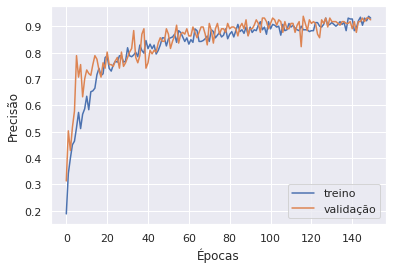

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Precisão')
plt.xlabel('Épocas')
plt.legend(['treino', 'validação']);

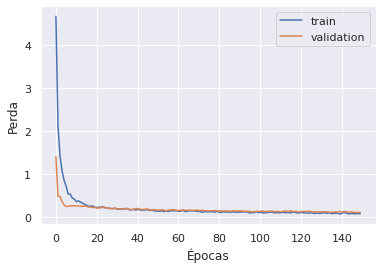

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Perda')
plt.xlabel('Épocas')
plt.legend(['train', 'validation']);

In [ ]:
predictions = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


In [ ]:
predictions = predictions.argmax(axis = 1)

In [ ]:
predictions = predictions.astype(int).flatten()
predictions = (labelencoder.inverse_transform((predictions)))

In [ ]:
predictions = pd.DataFrame({'Classes previstas': predictions})


In [ ]:
actual = y_test.argmax(axis = 1)
actual = actual.astype(int).flatten()
actual = labelencoder.inverse_transform(actual)
actual = pd.DataFrame({'Classes reais': actual})

In [ ]:
final_df = actual.join(predictions)
final_df

,Classes reais,Classes previstas
0,com-fala,com-fala
1,com-fala,com-fala
2,misto,misto
3,com-fala-ruido,com-fala-ruido
4,misto-ruido,misto-ruido
...,...,...
142,sem-fala-ruido,sem-fala-ruido
143,misto,misto
144,com-fala-ruido,com-fala-ruido
145,misto-ruido,misto-ruido


In [ ]:
cm = confusion_matrix(actual, predictions)
cm = pd.DataFrame(cm, index = [i for i in labelencoder.classes_], columns = [i for i in labelencoder.classes_])
cm

,com-fala,com-fala-ruido,misto,misto-ruido,sem-fala,sem-fala-ruido
com-fala,26,0,4,0,0,0
com-fala-ruido,0,24,0,1,0,0
misto,0,0,26,0,0,0
misto-ruido,0,1,0,22,0,5
sem-fala,0,0,0,0,16,0
sem-fala-ruido,0,0,0,0,0,22


Text(84.5, 0.5, 'Classes reais')

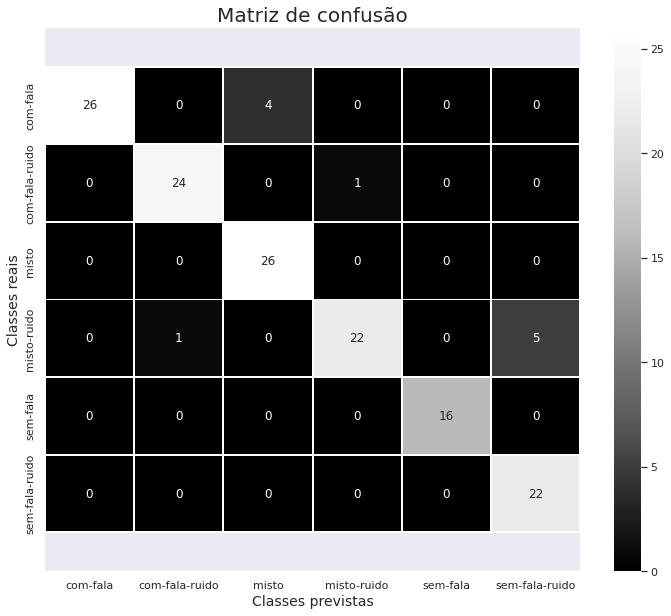

In [ ]:
plt.figure(figsize = (12,10))
ax = sns.heatmap(cm, linecolor = 'white', cmap = 'Greys_r', linewidth=1, annot = True, fmt = '')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de confusão', size = 20)
plt.xlabel('Classes previstas', size = 14)
plt.ylabel('Classes reais', size = 14)

In [ ]:
print(classification_report(actual, predictions))

                precision    recall  f1-score   support

      com-fala       1.00      0.87      0.93        30
com-fala-ruido       0.96      0.96      0.96        25
         misto       0.87      1.00      0.93        26
   misto-ruido       0.96      0.79      0.86        28
      sem-fala       1.00      1.00      1.00        16
sem-fala-ruido       0.81      1.00      0.90        22

      accuracy                           0.93       147
     macro avg       0.93      0.94      0.93       147
  weighted avg       0.93      0.93      0.92       147



##Testando o modelo

In [ ]:
def predict_sound(arquivo_audio):
  audio, sample_rate = librosa.load(arquivo_audio, sr = None, res_type = 'kaiser_best')
  mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
  mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
  mfccs_scaled_features = mfccs_scaled_features[:,:,np.newaxis]

  prediction = model.predict(mfccs_scaled_features)
  prediction = prediction.argmax(axis=1)
  prediction = prediction.astype(int).flatten()
  prediction = labelencoder.inverse_transform((prediction))

  print('Classificação/resultado: ', prediction)

In [ ]:
caminho = '/content/drive/My Drive/UTFPR/videos/video_final/'
caminho_final = []
classe_real = []
for root, dirs, files in os.walk(caminho):
  for file in files:
    try:
      concat = caminho + file
      caminho_final.append((concat))
      classe = file.split('-')[1]
      classe = int(classe.split('.')[0])
      classe_real.append(classe)
    except ValueError:
      continue

classe_real_dict = []
for classe in classe_real:
      if classe == 0:
        classe = 'sem-fala'
      if classe == 1:
        classe = 'com-fala'
      if classe == 2:
        classe = 'misto'
      if classe == 3:
        classe = 'sem-fala-ruido'
      if classe == 4:
        classe = 'com-fala-ruido'
      if classe == 5:
        classe = 'misto-ruido'
      classe_real_dict.append(classe)
      
print(classe_real)
print(classe_real_dict)

[0, 0, 1, 2, 0, 1, 2, 0, 1, 1, 2, 3, 4, 4, 3, 3, 4, 5, 0, 1, 1, 2, 0, 1]
['sem-fala', 'sem-fala', 'com-fala', 'misto', 'sem-fala', 'com-fala', 'misto', 'sem-fala', 'com-fala', 'com-fala', 'misto', 'sem-fala-ruido', 'com-fala-ruido', 'com-fala-ruido', 'sem-fala-ruido', 'sem-fala-ruido', 'com-fala-ruido', 'misto-ruido', 'sem-fala', 'com-fala', 'com-fala', 'misto', 'sem-fala', 'com-fala']


In [ ]:
i = 0
for caminho in caminho_final:
  print(caminho)
  print("Classe real do trecho de vídeo: ", classe_real_dict[i])
  predict_sound(caminho)
  print('\n')
  i = i + 1

/content/drive/My Drive/UTFPR/videos/video_final/001-0.wav
Classe real do trecho de vídeo:  sem-fala
1/1 [==============================] - 0s 17ms/step
Classificação/resultado:  ['sem-fala']


/content/drive/My Drive/UTFPR/videos/video_final/002-0.wav
Classe real do trecho de vídeo:  sem-fala
1/1 [==============================] - 0s 22ms/step
Classificação/resultado:  ['sem-fala']


/content/drive/My Drive/UTFPR/videos/video_final/003-1.wav
Classe real do trecho de vídeo:  com-fala
1/1 [==============================] - 0s 19ms/step
Classificação/resultado:  ['com-fala']


/content/drive/My Drive/UTFPR/videos/video_final/004-2.wav
Classe real do trecho de vídeo:  misto
1/1 [==============================] - 0s 20ms/step
Classificação/resultado:  ['misto']


/content/drive/My Drive/UTFPR/videos/video_final/005-0.wav
Classe real do trecho de vídeo:  sem-fala
1/1 [==============================] - 0s 18ms/step
Classificação/resultado:  ['sem-fala']


/content/drive/My Drive/UTFPR/videos